# Three Body Problem: Neural Network Training

A simple neural network is trained to learn approximate solutions to the three body problem.<br>
Data is sampled from three body systems that are perturbed versions of the Sun-Earth-Jupiter system.

In [1]:
# Library imports
import tensorflow as tf
import rebound
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style, range_inc
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from orbital_element import OrbitalElementToConfig, ConfigToOrbitalElement, MeanToTrueAnomaly, G_
from orbital_element import make_model_elt_to_cfg, make_model_cfg_to_elt

from jacobi import CartesianToJacobi, JacobiToCartesian

from g3b_data import make_traj_elts, make_data_g3b, make_datasets_g3b, traj_to_batch
from g3b_data import make_datasets_solar, make_datasets_hard
from g3b_data import combine_datasets_g3b, combine_datasets_solar
from sej_data import load_data_sej, make_datasets_sej, combine_datasets_sej
from sej_data import orb_elt_cov

from g3b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy, plot_orbit_element
from g3b import KineticEnergy_G3B, PotentialEnergy_G3B, Momentum_G3B, AngularMomentum_G3B
from g3b import VectorError, EnergyError
from g3b import Motion_G3B, make_physics_model_g3b
from g3b import fit_model
from g3b_model_math import make_position_model_g3b_math, make_model_g3b_math
from g3b_model_nn import make_position_model_g3b_nn, make_model_g3b_nn
from g3b_model_nn import baseline_loss

In [3]:
# Set active GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1:2], 'GPU')

In [4]:
# Grow GPU memory (must be first operation in TF)
# gpu_grow_memory()

In [5]:
# Lightweight serialization
# fname = '../data/g3b/g3b_train.pickle'
fname = '../data/sej/sej_train.pickle'
vartbl = load_vartbl(fname)

In [6]:
# Set plot style
plot_style()

### Load Data for General Three Body Problem

In [7]:
# Description of datasets to be loaded
n_years = 100
sample_freq = 10
traj_size = n_years * sample_freq + 1

In [8]:
# Configuration for loading data sets
# num_data_sets = 50
num_data_sets = 5
batch_size = 256
# num_gpus = 1
# full_batch_size = num_gpus * batch_size

# Set size of tiny data sets
n_traj_tiny = batch_size

# Set starting random seed
seed0 = 42

In [9]:
# Create a tiny data set with one batch of solar type orbits
ds_tiny_solar, _ , _ = \
    make_datasets_solar(n_traj=n_traj_tiny, vt_split=0.0, 
                        n_years=n_years, sample_freq=sample_freq,
                        batch_size=batch_size, seed=seed0)

Loaded data from ../data/g3b/1789961721.pickle.


W0822 21:11:42.268001 140501135808320 deprecation.py:323] From /home/michael/anaconda3/envs/nbody/lib/python3.7/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# Build combined solar data sets
# ds_solar_trn, ds_solar_val, ds_solar_tst = \
#     combine_datasets_solar(num_data_sets=num_data_sets, batch_size=batch_size, seed0=seed0)

### Load Data for Perturbed Sun-Earth-Jupiter System

In [11]:
# Orbital perturbation scales
scale_factor = 1.0
sd_q = scale_factor * np.array([0.00, 0.01, 0.05])
sd_v = sd_q

In [12]:
# Create a tiny data set with one batch of perturbed SEJ orbits
ds_tiny_sej, _ , _ = \
    make_datasets_sej(n_traj=n_traj_tiny, vt_split=0.0, n_years=n_years, sample_freq=sample_freq,
                      sd_q=sd_q, sd_v=sd_v,
                      batch_size=batch_size, seed=seed0,
                      assemble_datasets=True)

Loaded data from ../data/sej/1261268456.pickle.


In [13]:
# Create a tiny data set with the unperturbed SEJ system
ds_sej0, _, _ = \
    make_datasets_sej(n_traj=n_traj_tiny, vt_split=0.0, n_years=n_years, sample_freq=sample_freq,
                      sd_q=0.0, sd_v=0.0,
                      batch_size=batch_size, seed=0,
                      assemble_datasets=True)

Loaded data from ../data/sej/1521397475.pickle.


In [14]:
# Table of data sets keyed by scale factor
data_by_factor = dict()

In [15]:
# Build combined SEJ data sets with base scale factor
scale_factor = 1.0
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/3977083274.pickle.


Loaded data from ../data/sej/2722950989.pickle.
Loaded data from ../data/sej/400724224.pickle.
Loaded data from ../data/sej/3353493630.pickle.
Loaded data from ../data/sej/3130373179.pickle.



In [16]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

***Choose Data Set for Analysis: Solar vs. SEJ***

In [17]:
# Alias ds_trn, ds_val, ds_tst to selected source

# The selected data type for this analysis
data_type = 'SEJ'

# # Tables mapping data type to tuple of data sets
# data_by_type = {
#     # 'solar': (ds_tiny_solar, ds_solar_trn, ds_solar_val, ds_solar_tst),
#     'SEJ': (ds_tiny_sej, ds_sej_trn, ds_sej_val, ds_sej_tst)
# }

# # Perform the aliasing
# ds_tiny, ds_trn, ds_val, ds_tst = data_by_type[data_type]

ds_tiny = ds_tiny_sej

### Create the Kepler-Jacobi Model as a Benchmark

In [18]:
model_kj = make_model_g3b_math(traj_size=traj_size, batch_size=batch_size)

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=0.0)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H_loss'),
        'P': VectorError(name='P_loss', regularizer=1.0E-6),
        'L': VectorError(name='L_loss'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0E4,
                'v0_rec': 1.0E4,
                'H': 1.0,
                'P': 1.0,
                'L': 1.0}

In [20]:
# Compile the full mathematical model
model_kj.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [21]:
# Evaluate KJ model on unperturbed SEJ data set
model_kj.evaluate(ds_sej0)

1/1 [==============================] - 2s 2s/step - loss: 6.7071e-05 - q_loss: 1.9321e-05 - v_loss: 1.9308e-05 - a_loss: 2.8442e-05 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 6.6203e-14 - P_loss: 3.6133e-14 - L_loss: 1.1413e-14


[6.707102875225246e-05,
 1.9320656e-05,
 1.9308249e-05,
 2.844182e-05,
 9.793443e-15,
 2.0469324e-14,
 6.620291e-14,
 3.6132582e-14,
 1.1412751e-14]

In [22]:
# Evaluate KJ model on tiny data set
model_kj.evaluate(ds_tiny)

1/1 [==============================] - 0s 101ms/step - loss: 6.8487e-05 - q_loss: 1.9837e-05 - v_loss: 1.9812e-05 - a_loss: 2.8838e-05 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_loss: 9.5866e-14 - P_loss: 3.8770e-14 - L_loss: 2.0161e-14


[6.848739576525986e-05,
 1.9836736e-05,
 1.9811845e-05,
 2.883841e-05,
 2.0670675e-14,
 1.9992044e-14,
 9.5865854e-14,
 3.8770395e-14,
 2.0161029e-14]

In [23]:
# Evaluate KJ model on full validation data
model_kj.evaluate(ds_val)

35/35 [==============================] - 4s 119ms/step - loss: 6.7929e-05 - q_loss: 1.9743e-05 - v_loss: 1.9718e-05 - a_loss: 2.8467e-05 - q0_rec_loss: 1.9459e-14 - v0_rec_loss: 1.8404e-14 - H_loss: 9.5034e-14 - P_loss: 3.8634e-14 - L_loss: 2.0124e-14


[6.79291194371347e-05,
 1.9742967e-05,
 1.9718367e-05,
 2.8467404e-05,
 1.9458574e-14,
 1.8404181e-14,
 9.5034074e-14,
 3.8634403e-14,
 2.0123895e-14]

### Train the Neural Network Model

In [24]:
# Configuration for neural network model architecture
# hidden_sizes = []
hidden_sizes = [64, 16]
skip_layers = True

# Training configuration
learning_rate = 1.0E-7
kernel_reg = 1.0E-6
activity_reg = 0.0

In [25]:
# Build neural network model
model_nn = make_model_g3b_nn(hidden_sizes=hidden_sizes, skip_layers=skip_layers, 
                             kernel_reg=kernel_reg, activity_reg=activity_reg,
                             traj_size=traj_size, batch_size=batch_size)

In [26]:
# model_nn.summary()

In [27]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# optimizer = keras.optimizers.Adadelta()

In [28]:
# Compile the NN model
model_nn.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [29]:
# Evaluate the NN model on the unperturbed orbit
model_nn.evaluate(ds_sej0)

1/1 [==============================] - 2s 2s/step - loss: 6.7071e-05 - q_loss: 1.9321e-05 - v_loss: 1.9308e-05 - a_loss: 2.8442e-05 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 6.6203e-14 - P_loss: 3.6133e-14 - L_loss: 1.1413e-14


[6.707102875225246e-05,
 1.9320656e-05,
 1.9308249e-05,
 2.844182e-05,
 9.793443e-15,
 2.0469324e-14,
 6.620291e-14,
 3.6132582e-14,
 1.1412751e-14]

In [30]:
# Evaluate the NN model on the tiny data set
# model_nn.evaluate(ds_tiny)

In [ ]:
# Table with baseline losses by scale factor
baseline_tbl = dict()

In [31]:
# Evaluate the KJ model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

35/35 [==============================] - 4s 116ms/step - loss: 6.7929e-05 - q_loss: 1.9743e-05 - v_loss: 1.9718e-05 - a_loss: 2.8467e-05 - q0_rec_loss: 1.9459e-14 - v0_rec_loss: 1.8404e-14 - H_loss: 9.5034e-14 - P_loss: 3.8634e-14 - L_loss: 2.0124e-14


In [ ]:
# Set up training - shared variables

# Suffix to the model name reflects layer sizes
suffix = '_'.join(str(sz) for sz in hidden_sizes)

# The model code is g3b or sej based on type of data
if data_type == 'solar':   
    model_code = 'g3b'
elif data_type == 'SEJ':
    model_code = 'sej'

# The folder is the same as the model code
folder = model_code

# How often to save weights to disk
save_freq = 'epoch'

In [40]:
# Set up training - unperturbed SEJ system (ds_sej0)
model_name = f'model_{model_code}_nn_{suffix}_sej0'

# Number of training epochs
epochs = 20

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'model_nn.name = {model_nn.name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

model_nn.name = model_g3b_nn_64_16
model_h5 = ../models/sej/model_sej_nn_64_16_sej0.h5
hist_name = hist_sej_nn_64_16_sej0


### Train on Unperturbed Model (ds_sej0)

In [44]:
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    hist = fit_model(model=model_nn,
                     model_name=model_name,
                     folder=folder,
                     ds=ds_sej0, 
                     epochs=20,
                     save_freq=save_freq,
                     prev_history = hist0, 
                     batch_num=1)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Loaded model_sej_nn_64_16_sej0 from ../models/sej/model_sej_nn_64_16_sej0.h5.


In [45]:
model_nn.evaluate(ds_sej0)

1/1 [==============================] - 2s 2s/step - loss: 1.7083e-06 - q_loss: 2.8683e-07 - v_loss: 2.7676e-07 - a_loss: 1.1392e-06 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 4.6671e-12 - P_loss: 4.0580e-14 - L_loss: 5.0551e-09


[1.7083234524761792e-06,
 2.8683183e-07,
 2.7676313e-07,
 1.1391754e-06,
 9.793443e-15,
 2.0469324e-14,
 4.6670996e-12,
 4.057985e-14,
 5.055112e-09]

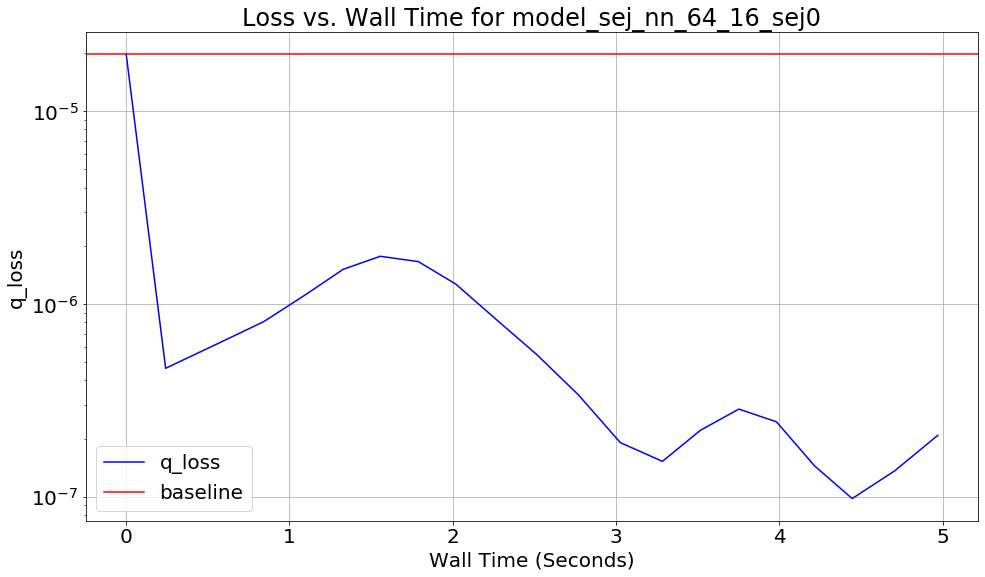

In [46]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Tiny Data Set

In [48]:
# Set up training - tiny data set
model_name = f'model_{model_code}_nn_{suffix}_tiny'

# Number of training epochs
epochs = 20

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'model_nn.name = {model_nn.name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

model_nn.name = model_g3b_nn_64_16
model_h5 = ../models/sej/model_sej_nn_64_16_tiny.h5
hist_name = hist_sej_nn_64_16_tiny


In [50]:
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    hist = fit_model(model=model_nn,
                     model_name=model_name,
                     folder=folder,
                     ds=ds_sej0, 
                     epochs=20,
                     save_freq=save_freq,
                     prev_history = hist0, 
                     batch_num=1)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Loaded model_sej_nn_64_16_tiny from ../models/sej/model_sej_nn_64_16_tiny.h5.


In [51]:
model_nn.evaluate(ds_tiny)

1/1 [==============================] - 2s 2s/step - loss: 8.3420e-06 - q_loss: 2.3300e-06 - v_loss: 2.3110e-06 - a_loss: 3.6995e-06 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_loss: 1.4544e-11 - P_loss: 3.9307e-14 - L_loss: 8.6505e-10


[8.341977263626177e-06,
 2.330004e-06,
 2.3110224e-06,
 3.6994538e-06,
 2.0670675e-14,
 1.9992044e-14,
 1.4544376e-11,
 3.9307455e-14,
 8.6504964e-10]

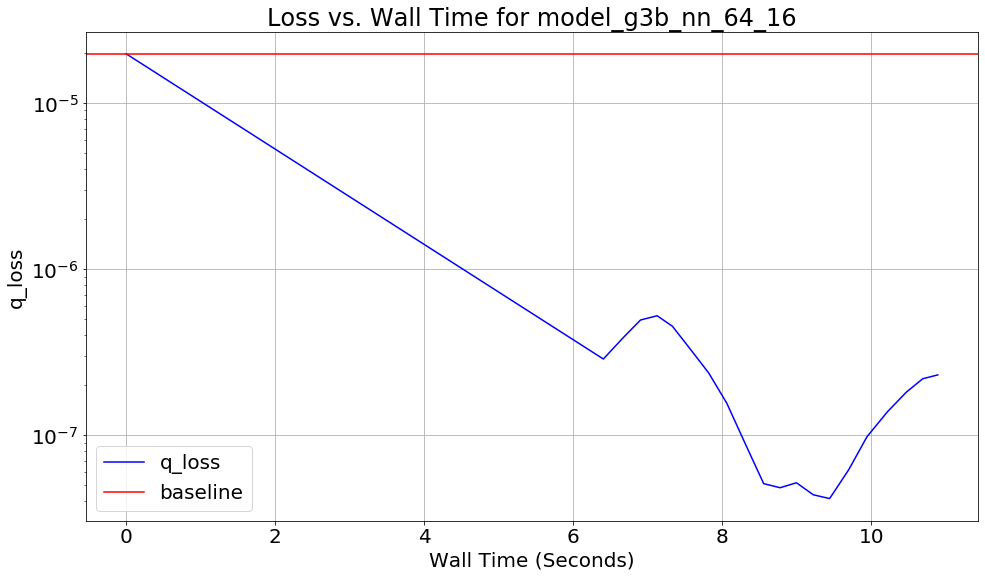

In [52]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 1.0

In [53]:
# Scale factor
scale_factor = 1.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = data_by_factor[scale_factor]

In [ ]:
# Evaluate the KJ model on the validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

In [58]:
# Set up training - full data, scale factor = 1

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

Training for 1 batches of 5 epochs each.
model_name = model_sej_nn_64_16_sf_1
model_h5 = ../models/sej/model_sej_nn_64_16_sf_1.h5
hist_name = hist_sej_nn_64_16_sf_1


In [59]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Unable to load model_sej_nn_64_16_sf_1 from ../models/sej/model_sej_nn_64_16_sf_1.h5. Fitting...
*** Training batch   1 *** 2019-08-22 21:28:21
Epoch 1/5
194/195 [============================>.] - ETA: 0s - loss: 1.6530e-06 - q_loss: 2.6687e-07 - v_loss: 2.4733e-07 - a_loss: 1.1382e-06 - q0_rec_loss: 1.9386e-14 - v0_rec_loss: 1.8410e-14 - H_loss: 3.0977e-12 - P_loss: 3.9213e-14 - L_loss: 6.8820e-11
Epoch 0001; loss 1.65e-06; elapsed 0:00:56
195/195 [==============================] - 47s 241ms/step - loss: 1.6523e-06 - q_loss: 2.6664e-07 - v_loss: 2.4709e-07 - a_loss: 1.1379e-06 - q0_rec_loss: 1.9384e-14 - v0_rec_loss: 1.8411e-14 - H_loss: 3.0824e-12 - P_loss: 3.9213e-14 - L_loss: 6.8472e-11
Epoch 2/5
194/195 [============================>.] - ETA: 0s - loss: 1.3510e-06 - q_loss: 1.8260e-07 - v_loss: 1.6399e-07 - a_loss: 1.0038e-06 - q0_rec_loss: 1.9386e-14 - v0_rec_loss: 1.8410e-14 - H_loss: 1.0166e-13 - P_loss: 3.9184e-14 - L_loss: 6.2119e-13
Epoch 0002; loss 1.35e-06; elapsed 0:01:43

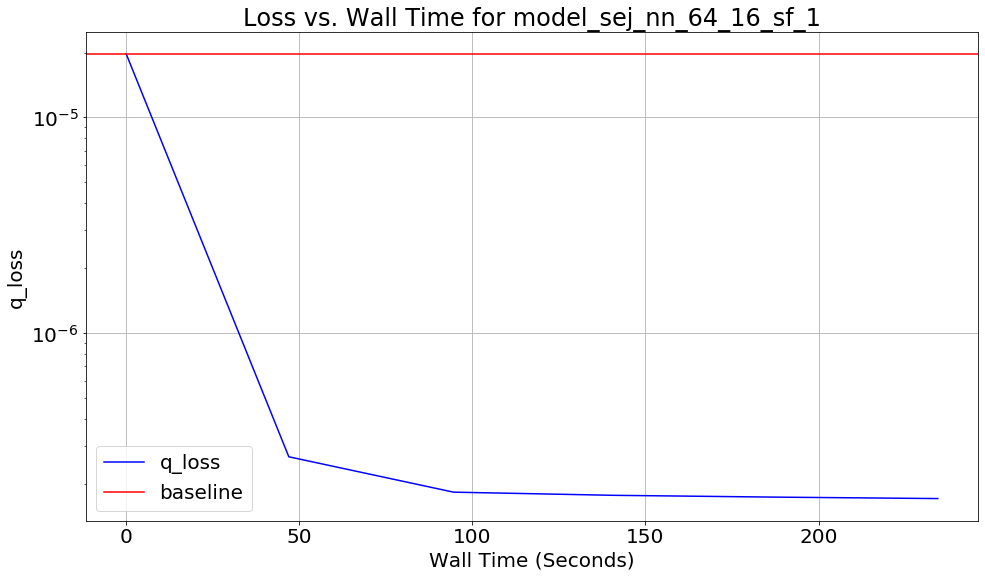

In [60]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

In [ ]:
# Plot the total loss
# fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='loss')

In [ ]:
# Evaluate the trained model on the training data
# model_nn.evaluate(ds_trn)

In [61]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

35/35 [==============================] - 4s 123ms/step - loss: 1.2410e-06 - q_loss: 1.5417e-07 - v_loss: 1.4002e-07 - a_loss: 9.4575e-07 - q0_rec_loss: 1.9459e-14 - v0_rec_loss: 1.8404e-14 - H_loss: 1.0394e-13 - P_loss: 3.9199e-14 - L_loss: 3.6042e-10


[1.2410399676809902e-06,
 1.541737e-07,
 1.4002185e-07,
 9.457511e-07,
 1.9458574e-14,
 1.8404181e-14,
 1.039366e-13,
 3.919922e-14,
 3.6042241e-10]

In [ ]:
# Evaluate the trained model on the test data
# model_nn.evaluate(ds_tst)

### Describe Covariance of Dataset Orbital Elements

In [62]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [63]:
# List of orbital elements in the cov matrix
elt_names = ['a1', 'a2', 'e1', 'e2', 'inc1', 'inc2', 'Omega1', 'Omega2', 'omega1', 'omega2', 'f1', 'f2']
# limit to the interesting ones
elt_names = elt_names[0:6]

In [64]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

SD of a1     = 0.021019
SD of a2     = 0.228333
SD of e1     = 0.009339
SD of e2     = 0.030154
SD of inc1   = 0.005925
SD of inc2   = 0.011256


### Train on Full Data Set with Perturbation Scale Factor = 2.0

In [65]:
# Build combined SEJ data sets with scale factor = 2
scale_factor = 2.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/3461170694.pickle.


Loaded data from ../data/sej/2165100737.pickle.
Loaded data from ../data/sej/883076748.pickle.
Loaded data from ../data/sej/3835854834.pickle.
Loaded data from ../data/sej/2580908983.pickle.



In [66]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [67]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [68]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

SD of a1     = 0.042134
SD of a2     = 0.472072
SD of e1     = 0.015736
SD of e2     = 0.050770
SD of inc1   = 0.011849
SD of inc2   = 0.020815


In [70]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

35/35 [==============================] - 4s 116ms/step - loss: 6.8835e-05 - q_loss: 2.0331e-05 - v_loss: 2.0267e-05 - a_loss: 2.8237e-05 - q0_rec_loss: 2.2697e-14 - v0_rec_loss: 2.2183e-14 - H_loss: 1.0033e-13 - P_loss: 3.8083e-14 - L_loss: 2.0160e-14


In [71]:
# Set up training - full data, scale factor = 2

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

Training for 1 batches of 5 epochs each.
model_name = model_sej_nn_64_16_sf_2
model_h5 = ../models/sej/model_sej_nn_64_16_sf_2.h5
hist_name = hist_sej_nn_64_16_sf_2


In [72]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Unable to load model_sej_nn_64_16_sf_2 from ../models/sej/model_sej_nn_64_16_sf_2.h5. Fitting...
*** Training batch   1 *** 2019-08-22 21:40:06
Epoch 1/5
194/195 [============================>.] - ETA: 0s - loss: 1.5204e-06 - q_loss: 3.0688e-07 - v_loss: 2.7280e-07 - a_loss: 9.3901e-07 - q0_rec_loss: 2.2892e-14 - v0_rec_loss: 2.2396e-14 - H_loss: 1.4890e-13 - P_loss: 3.8644e-14 - L_loss: 8.1554e-10
Epoch 0001; loss 1.52e-06; elapsed 0:00:48
195/195 [==============================] - 39s 202ms/step - loss: 1.5201e-06 - q_loss: 3.0687e-07 - v_loss: 2.7280e-07 - a_loss: 9.3880e-07 - q0_rec_loss: 2.2880e-14 - v0_rec_loss: 2.2382e-14 - H_loss: 1.4988e-13 - P_loss: 3.8644e-14 - L_loss: 8.1193e-10
Epoch 2/5
194/195 [============================>.] - ETA: 0s - loss: 1.4777e-06 - q_loss: 2.9384e-07 - v_loss: 2.6573e-07 - a_loss: 9.1681e-07 - q0_rec_loss: 2.2892e-14 - v0_rec_loss: 2.2396e-14 - H_loss: 2.0046e-11 - P_loss: 3.8648e-14 - L_loss: 3.8283e-10
Epoch 0002; loss 1.48e-06; elapsed 0:01:34

In [73]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

35/35 [==============================] - 4s 125ms/step - loss: 1.3923e-06 - q_loss: 2.3033e-07 - v_loss: 2.0835e-07 - a_loss: 9.5262e-07 - q0_rec_loss: 2.2697e-14 - v0_rec_loss: 2.2183e-14 - H_loss: 4.7692e-13 - P_loss: 3.8678e-14 - L_loss: 4.0333e-13


[1.3922762556311293e-06,
 2.3032514e-07,
 2.083513e-07,
 9.526169e-07,
 2.269701e-14,
 2.2183288e-14,
 4.7692145e-13,
 3.8677703e-14,
 4.03329e-13]

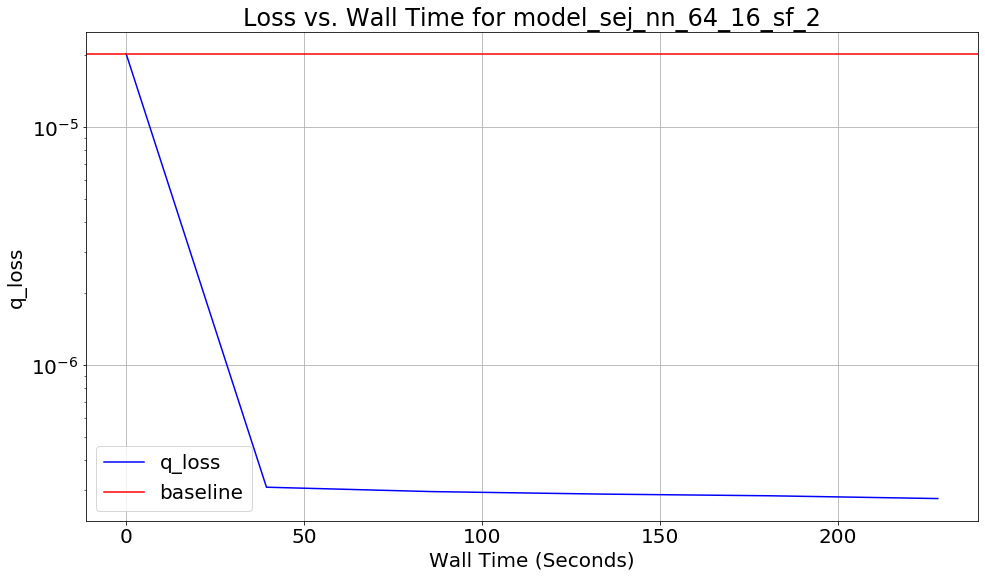

In [74]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 4.0

In [75]:
# Build combined SEJ data sets with scale factor = 4
scale_factor = 4.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/109948493.pickle.


Loaded data from ../data/sej/1238120586.pickle.
Loaded data from ../data/sej/4234299079.pickle.
Loaded data from ../data/sej/744658873.pickle.
Loaded data from ../data/sej/1360356348.pickle.



In [78]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [79]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [80]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

SD of a1     = 0.085013
SD of a2     = 1.119090
SD of e1     = 0.028830
SD of e2     = 0.093952
SD of inc1   = 0.023712
SD of inc2   = 0.039768


In [81]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)

35/35 [==============================] - 4s 117ms/step - loss: 1.2033e-04 - q_loss: 3.7668e-05 - v_loss: 3.7125e-05 - a_loss: 4.5541e-05 - q0_rec_loss: 2.4782e-14 - v0_rec_loss: 2.5038e-14 - H_loss: 1.1407e-13 - P_loss: 3.6273e-14 - L_loss: 2.0457e-14


In [82]:
# Set up training - full data, scale factor = 4

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

Training for 1 batches of 5 epochs each.
model_name = model_sej_nn_64_16_sf_4
model_h5 = ../models/sej/model_sej_nn_64_16_sf_4.h5
hist_name = hist_sej_nn_64_16_sf_4


In [83]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Unable to load model_sej_nn_64_16_sf_4 from ../models/sej/model_sej_nn_64_16_sf_4.h5. Fitting...
*** Training batch   1 *** 2019-08-22 21:46:39
Epoch 1/5
194/195 [============================>.] - ETA: 0s - loss: 1.5772e-04 - q_loss: 5.2247e-05 - v_loss: 5.1960e-05 - a_loss: 5.3514e-05 - q0_rec_loss: 2.5150e-14 - v0_rec_loss: 2.5211e-14 - H_loss: 1.9874e-10 - P_loss: 3.6803e-14 - L_loss: 8.3911e-10
Epoch 0001; loss 1.57e-04; elapsed 0:00:48
195/195 [==============================] - 40s 205ms/step - loss: 1.5697e-04 - q_loss: 5.1998e-05 - v_loss: 5.1711e-05 - a_loss: 5.3259e-05 - q0_rec_loss: 2.5167e-14 - v0_rec_loss: 2.5229e-14 - H_loss: 1.9780e-10 - P_loss: 3.6804e-14 - L_loss: 8.3485e-10
Epoch 2/5
194/195 [============================>.] - ETA: 0s - loss: 1.5715e-04 - q_loss: 5.2103e-05 - v_loss: 5.1814e-05 - a_loss: 5.3231e-05 - q0_rec_loss: 2.5150e-14 - v0_rec_loss: 2.5211e-14 - H_loss: 1.0927e-11 - P_loss: 3.6798e-14 - L_loss: 7.7935e-10
Epoch 0002; loss 1.56e-04; elapsed 0:01:36

In [84]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

35/35 [==============================] - 4s 123ms/step - loss: 4.7046e-05 - q_loss: 1.5708e-05 - v_loss: 1.5314e-05 - a_loss: 1.6022e-05 - q0_rec_loss: 2.4782e-14 - v0_rec_loss: 2.5038e-14 - H_loss: 1.3387e-10 - P_loss: 3.6809e-14 - L_loss: 2.7337e-10


[4.704592701533069e-05,
 1.5708436e-05,
 1.531431e-05,
 1.6021548e-05,
 2.4781589e-14,
 2.5038285e-14,
 1.3387116e-10,
 3.6809382e-14,
 2.7337135e-10]

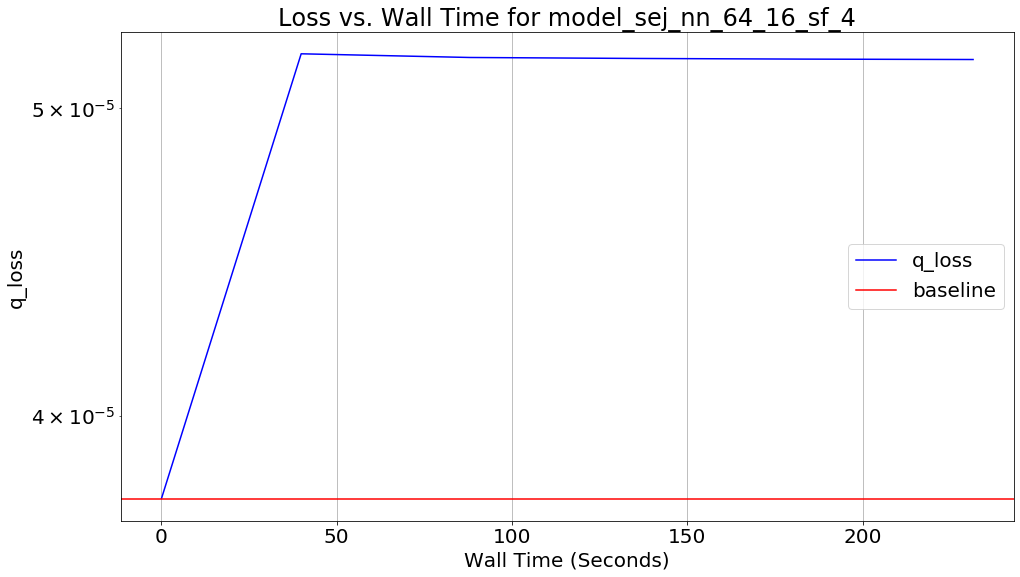

In [85]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 8.0

In [98]:
# Build combined SEJ data sets with scale factor = 8
scale_factor = 8.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/1283291290.pickle.


Loaded data from ../data/sej/54324829.pickle.
Loaded data from ../data/sej/3063058448.pickle.
Loaded data from ../data/sej/1720861038.pickle.
Loaded data from ../data/sej/468038955.pickle.


In [99]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [100]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [101]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

SD of a1     = 0.176228
SD of a2     = 48.840700
SD of e1     = 0.055955
SD of e2     = 0.191019
SD of inc1   = 0.047594
SD of inc2   = 0.079361


In [97]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

35/35 [==============================] - 4s 122ms/step - loss: 1.2033e-04 - q_loss: 3.7668e-05 - v_loss: 3.7125e-05 - a_loss: 4.5541e-05 - q0_rec_loss: 2.4782e-14 - v0_rec_loss: 2.5038e-14 - H_loss: 1.1407e-13 - P_loss: 3.6273e-14 - L_loss: 2.0457e-14


In [95]:
model_nn.evaluate(ds_val)

35/35 [==============================] - 4s 119ms/step - loss: nan - q_loss: nan - v_loss: nan - a_loss: nan - q0_rec_loss: nan - v0_rec_loss: nan - H_loss: nan - P_loss: nan - L_loss: nan


[nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [ ]:
# Set up training - full data, scale factor = 8

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

In [ ]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 16.0

In [ ]:
# Build combined SEJ data sets with scale factor = 16
scale_factor = 16.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

In [ ]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [ ]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [ ]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

In [ ]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

In [ ]:
# Set up training - full data, scale factor = 16

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

In [ ]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 32.0

In [ ]:
# Build combined SEJ data sets with scale factor = 32
scale_factor = 32.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

In [ ]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [ ]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [ ]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

In [ ]:
# Evaluate the NN model on the full validation data; save as baseline
hist0, q_loss_baseline = baseline_loss(model_kj, ds_val)
baseline_tbl[scale_factor] = q_loss_baseline

In [ ]:
# Set up training - full data, scale factor = 2

# Number of training epochs
num_batches=1
epochs_per_batch = 5

# Integer scale factor
sfi = int(scale_factor)

# Name of this model including scale factor
model_name = f'model_{model_code}_nn_{suffix}_sf_{sfi}'

# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
# Name of the loss history in vartbl
hist_name = model_name.replace('model_', 'hist_')

# Status
print(f'Training for {num_batches} batches of {epochs_per_batch} epochs each.')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

In [ ]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training batch {i:3} *** {st}')
        hist = fit_model(model=model_nn,
                         model_name=model_name,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs_per_batch,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 64.0

### Train on Full Data Set with Perturbation Scale Factor = 128.0

### Train on Full Data Set with Perturbation Scale Factor = 256.0